In [1]:
import os
import json
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedGroupKFold
import matplotlib.pyplot as plt
%matplotlib inline
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)

In [2]:
# function to return the cv splits by index

def fetch_cv_indicies(X, y, g):
    sgkf = StratifiedGroupKFold(n_splits=10)
    sgkf.get_n_splits(X, y)
    cv_splits = sgkf.split(X, y, g)
        
    return cv_splits


In [3]:
def load_data(data_path, target_labels):
    
    with open(data_path, "r") as fp:
        data = json.load(fp)
        
    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data[target_labels]).astype(int)
    g = np.array(data['fold_label'])

    print("Data successfully loaded!")

    return  X, y, g

In [4]:
mfcc_path = '../data/processed/13_mfcc_5_train.json'

In [5]:
# load data
X, y, g = load_data(data_path=mfcc_path, target_labels='subclass_label')

Data successfully loaded!


In [6]:
def build_model():
    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
        keras.layers.BatchNormalization(),

        # 1st dense layer
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),
        

        # 2nd dense layer
        keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),

        # output layer
        keras.layers.Dense(5, activation='softmax')
    ])

    # compile model
    optimizer = keras.optimizers.Adadelta()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    return model

In [7]:
iters = 0
scores = []
devs = []
cum_ave = []

weights = {0: 0.7, 1: 7, 2: 2, 3: 0.5, 4: 25}

while iters < 50:
    
    iters += 1
        
    # evaluate model with cv splits
    model = KerasClassifier(model=build_model, 
                            batch_size=260, 
                            epochs=100, 
                            random_state=iters, 
                            verbose=0,
                            class_weight=weights)

    results = cross_validate(model, X, y, cv=fetch_cv_indicies(X, y, g), n_jobs=-1)
    print(f"{iters}) Acc: %.2f%% (%.2f%%)" % (results['test_score'].mean()*100, results['test_score'].std()*100))

    scores.append(results['test_score'].mean()*100)
    devs.append(results['test_score'].std()*100)
    cum_ave.append(np.array(scores).mean())
    
    
    
print(f"After {iters} iterations) Baseline: %.2f%% (%.2f%%)" % (np.array(scores).mean(), np.array(devs).mean()))


1) Acc: 72.68% (9.26%)
2) Acc: 72.27% (8.39%)
3) Acc: 63.63% (8.62%)
4) Acc: 67.46% (8.87%)
5) Acc: 75.07% (6.49%)
6) Acc: 72.34% (6.72%)
7) Acc: 73.30% (7.65%)
8) Acc: 73.75% (7.89%)
9) Acc: 70.53% (7.89%)
10) Acc: 74.90% (9.30%)
11) Acc: 65.51% (10.69%)
12) Acc: 77.79% (8.61%)
13) Acc: 69.80% (8.98%)
14) Acc: 73.19% (8.17%)
15) Acc: 70.47% (9.13%)
16) Acc: 76.08% (8.15%)
17) Acc: 71.99% (8.08%)
18) Acc: 74.68% (8.02%)
19) Acc: 66.92% (10.84%)
20) Acc: 63.77% (7.26%)
21) Acc: 68.28% (8.47%)
22) Acc: 73.72% (7.94%)
23) Acc: 65.81% (12.38%)
24) Acc: 75.34% (5.35%)
25) Acc: 81.05% (7.78%)
26) Acc: 75.60% (7.95%)
27) Acc: 75.24% (9.19%)
28) Acc: 72.18% (6.69%)
29) Acc: 63.37% (8.47%)
30) Acc: 74.78% (7.99%)
31) Acc: 72.90% (6.53%)
32) Acc: 73.83% (6.36%)
33) Acc: 74.62% (6.92%)
34) Acc: 74.02% (7.28%)
35) Acc: 65.68% (9.16%)
36) Acc: 71.20% (11.13%)
37) Acc: 65.36% (9.65%)
38) Acc: 71.63% (6.38%)
39) Acc: 66.57% (11.37%)
40) Acc: 75.88% (6.33%)
41) Acc: 69.13% (5.24%)
42) Acc: 74.39% (10.

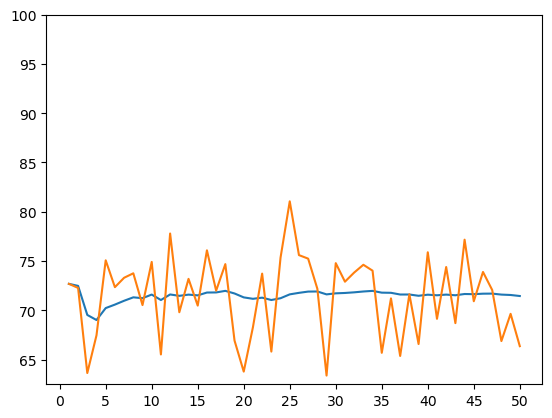

In [8]:
# plot the cumulative average of accuracy
x = range(1, len(scores)+1, 1)
y_cum = cum_ave
plt.plot(x, y_cum)
plt.plot(x, scores)
plt.xticks(range(0, len(scores)+1, 5))
plt.ylim(top=100)
plt.show()

In [9]:
print(f"\nBaseline after {iters} iterations of 10-fold cross-validation:\n\nMean Accuracy: %.2f%% (%.2f%%)\nMean St Dev: (%.2f%%)" % (np.array(scores).mean(), np.array(scores).std(), np.array(devs).mean()))


Baseline after 50 iterations of 10-fold cross-validation:

Mean Accuracy: 71.45% (4.05%)
Mean St Dev: (8.15%)
